Face recognition

# **Importation des librairies et données**

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 13 18:27:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import sys
import os
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
from IPython.display import Image

In [7]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [9]:
folder='Gdrive' #@param ['Gdrive']
if folder == 'Gdrive' :
  faceRecognition_path = "/content/drive/MyDrive/Workshop/1. Face recognition"
sys.path.append(faceRecognition_path)
os.chdir(faceRecognition_path)
import Yoda
from Yoda import FaceRecognition

pic_names=os.listdir(faceRecognition_path +'/'+ 'Personnes_autorisees')

video_path='Webcam' #@param ['Une vie _ Barack Obama.mp4','Trump_Clinton.mp4','Webcam']
if video_path!='Webcam':
  video_path= faceRecognition_path + '/' + video_path


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Encoder les personnes autorisées**

In [11]:
model = FaceRecognition()
images_paths = [faceRecognition_path+'/'+'Personnes_autorisees'+'/'+pic_name  for pic_name in pic_names]
images = [model.load_image_file(images_path) for images_path in images_paths]
known_face_encodings = [model.face_embeddings(image)[0] for image in images]
known_face_names=[pic_name[:-4] for pic_name in pic_names]
print(known_face_names)

['biden', 'obama', 'Hillary_Clinton', 'Adrien D']


# **Lecture**

<IPython.core.display.Javascript object>

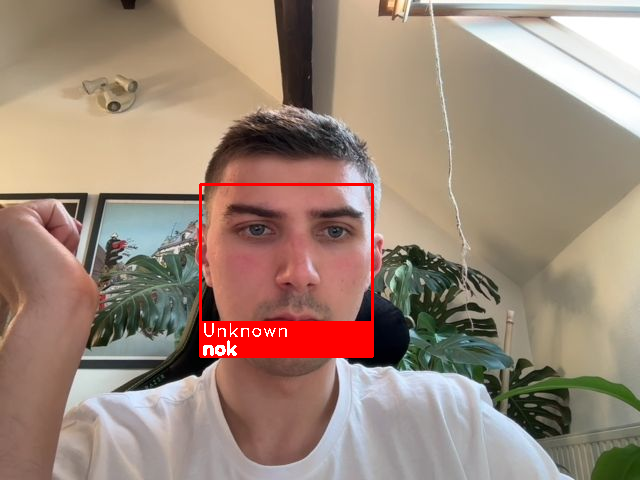


personnes autorisées requises !


In [17]:
valid_last=''
if video_path=='Webcam':
  valid_last=lecture_webcam()
else:
  valid_last=lecture_video()
if valid_last=='ok':
  print('démarrage du programme...')
else:
  print('personnes autorisées requises !')

# **Fonctions pour lecture d'une video**

In [13]:
def lecture_video():
  # Initialize some variables
  face_locations = []
  face_encodings = []
  face_names = []
  process_this_frame = True
  valid_last='nok'

  font = cv2.FONT_HERSHEY_DUPLEX
  fontScale1=0.6
  fontScale2=0.6

  #activer le flux vidéo
  cap = cv2.VideoCapture(video_path)
  if (cap.isOpened()== False):
    print("vérifier la vidéo ou son chemin")
    exit()

  #afficher les FPS et adapter le temps d'attente en fonction
  FPS=cap.get(cv2.CAP_PROP_FPS)
  waiting_time=int(1/FPS*1000)
  #print(FPS)
  width  = cap.get(3)
  #print(width)
  height=cap.get(4)
  #print(height)
  f_resize=250/width
  f_reresize=int(1/f_resize)


  # tant qu'il y a un flux, capter les frames et y afficher les noms trouvés
  while(cap.isOpened()):
      # Capture frame-by-frame
      ret, frame = cap.read()



      if not ret:
        print("oui j'arrête, mais il n'y a pas le feu !!!")
        break

      # Resize frame of video to 1/4 size for faster face recognition processing
      small_frame = cv2.resize(frame, (0, 0), fx=f_resize, fy=f_resize)

      # Convert the image from BGR color (which OpenCV uses) to RGB color (which FaceRecognition uses)
      #rgb_small_frame = small_frame[:, :, ::-1]
      rgb_small_frame = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)
      #rgb_small_frame = np.ascontiguousarray(small_frame[:, :, ::-1])

      # Only process every other frame of video to save time
      if process_this_frame:
          # Find all the faces and face encodings in the current frame of video
          face_locations = model.find_face_locations(rgb_small_frame)
          face_encodings = model.face_embeddings(rgb_small_frame, face_locations)

          face_names = []

          for face_encoding in face_encodings:
              # See if the face is a match for the known face(s)
              matches = model.compare_faces(known_face_encodings, face_encoding)
              name = "Unknown"

              # If a match was found in known_face_encodings, just use the first one.
              if True in matches:
                  first_match_index = matches.index(True)
                  name = known_face_names[first_match_index]

              face_names.append(name)

      process_this_frame = not process_this_frame


      # Display the results
      for d, name in zip(face_locations, face_names):
          # Scale back up face locations since the frame we detected in was scaled to 1/4 size
          top = d.top() * f_reresize
          right = d.right() * f_reresize
          bottom = d.bottom() * f_reresize
          left = d.left() * f_reresize

          if name=="Unknown":
            color=(0, 0, 255)
            valid='nok'
          else:
            color=(0, 255,0)
            valid='carte blanche'
            valid_last='ok'

          # Draw a box around the face
          cv2.rectangle(frame, (left, top), (right, bottom), color, 2)

          # Draw a label with a name below the face
          cv2.rectangle(frame, (left, bottom - 35), (right, bottom), color, cv2.FILLED)
          cv2.putText(frame, name , (left + 2, bottom - 20), font, fontScale1, (255, 255, 255), 1)
          cv2.putText(frame,valid, (left + 2, bottom - 2), font, fontScale2, (255, 255, 255), 2)

      # Display the resulting image
      cv2_imshow(frame)

      #attendre entre chaque frame
      #key=cv2.waitKey(waiting_time)

      # Hit 'q' on the keyboard to quit!
      if cv2.waitKey(1) & 0xFF == ord('q'):
          break

  # arrêter le flux
  cap.release()
  cv2.destroyAllWindows()
  return(valid_last)

# **Fonctions pour lecture Webcam**

In [14]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])

  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [15]:
def print_boxes(filename):
  # Initialize some variables
  face_locations = []
  face_encodings = []
  face_names = []
  font = cv2.FONT_HERSHEY_DUPLEX
  fontScale1=0.6
  fontScale2=0.6

  frame = cv2.imread(filename)
  f_resize=0.25
  f_reresize=int(1/f_resize)

  small_frame = cv2.resize(frame, (0, 0), fx=f_resize, fy=f_resize)
   # Convert the image from BGR color (which OpenCV uses) to RGB color (which FaceRecognition uses)
  #rgb_small_frame = small_frame[:, :, ::-1]
  rgb_small_frame = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)
  #rgb_small_frame = np.ascontiguousarray(small_frame[:, :, ::-1])

  # Find all the faces and face encodings in the current frame of video
  face_locations = model.find_face_locations(rgb_small_frame)
  face_encodings = model.face_embeddings(rgb_small_frame, face_locations)
  face_names = []
  valid_last='nok'
  for face_encoding in face_encodings:
    # See if the face is a match for the known face(s)
    matches = model.compare_faces(known_face_encodings, face_encoding)
    name = "Unknown"

    # If a match was found in known_face_encodings, just use the first one.
    if True in matches:
        first_match_index = matches.index(True)
        name = known_face_names[first_match_index]
    face_names.append(name)

  # Display the results
  for d, name in zip(face_locations, face_names):
    # Scale back up face locations since the frame we detected in was scaled to 1/4 size
    top = d.top() * f_reresize
    right = d.right() * f_reresize
    bottom = d.bottom() * f_reresize
    left = d.left() * f_reresize

    if name=='Unknown':
      color=(0, 0, 255)
      valid='nok'
    else:
      color=(0, 255,0)
      valid='carte blanche'
      valid_last='ok'

    # Draw a box around the face
    cv2.rectangle(frame, (left, top), (right, bottom), color, 2)

    # Draw a label with a name below the face
    cv2.rectangle(frame, (left, bottom - 35), (right, bottom), color, cv2.FILLED)
    cv2.putText(frame, name , (left + 2, bottom - 20), font, fontScale1, (255, 255, 255), 1)
    cv2.putText(frame,valid, (left + 2, bottom - 2), font, fontScale2, (255, 255, 255), 2)

  # Display the resulting image
  cv2_imshow(frame)

  return(valid_last)

In [16]:
def lecture_webcam():
  try:
    filename = take_photo()
    #print('Saved to {}'.format(filename))
    valid_last=print_boxes(filename)
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))
  print()
  return(valid_last)



# **Prise de photo sans cadre**

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# brouillon webcam

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data


In [ ]:
# Initialize some variables
face_locations = []
face_encodings = []
face_names = []
process_this_frame = True

font = cv2.FONT_HERSHEY_DUPLEX
fontScale1=0.6
fontScale2=0.6

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

      #afficher les FPS et adapter le temps d'attente en fonction
    #FPS=cap.get(cv2.CAP_PROP_FPS)
    #waiting_time=int(1/FPS*1000)
    #print(FPS)
    #width  = cap.get(3)
    #print(width)
    #height=cap.get(4)
    #print(height)
    #f_resize=250/width
    #f_reresize=int(1/f_resize)
    f_resize=0.25
    f_reresize=int(1/f_resize)

        # Resize frame of video to 1/4 size for faster face recognition processing
    small_frame = cv2.resize(frame, (0, 0), fx=f_resize, fy=f_resize)

    # Convert the image from BGR color (which OpenCV uses) to RGB color (which FaceRecognition uses)
    #rgb_small_frame = small_frame[:, :, ::-1]
    rgb_small_frame = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)
    #rgb_small_frame = np.ascontiguousarray(small_frame[:, :, ::-1])

    # Only process every other frame of video to save time
    if process_this_frame:
        # Find all the faces and face encodings in the current frame of video
        face_locations = model.find_face_locations(rgb_small_frame)
        face_encodings = model.face_embeddings(rgb_small_frame, face_locations)

        face_names = []
        for face_encoding in face_encodings:
            # See if the face is a match for the known face(s)
            matches = model.compare_faces(known_face_encodings, face_encoding)
            name = "Unknown"

            # If a match was found in known_face_encodings, just use the first one.
            if True in matches:
                first_match_index = matches.index(True)
                name = known_face_names[first_match_index]

            face_names.append(name)

    process_this_frame = not process_this_frame


    # Display the results
    for d, name in zip(face_locations, face_names):
        # Scale back up face locations since the frame we detected in was scaled to 1/4 size
        top = d.top() * f_reresize
        right = d.right() * f_reresize
        bottom = d.bottom() * f_reresize
        left = d.left() * f_reresize

        if name=="Unknown":
          color=(0, 0, 255)
          valid='nok'
        else:
          color=(0, 255,0)
          valid='carte blanche'

        # Draw a box around the face
        cv2.rectangle(frame, (left, top), (right, bottom), color, 2)

        # Draw a label with a name below the face
        bbox_array=cv2.rectangle(frame, (left, bottom - 35), (right, bottom), color, cv2.FILLED)
        bbox_array=cv2.putText(frame, name , (left + 2, bottom - 20), font, fontScale1, (255, 255, 255), 1)
        bbox_array=cv2.putText(frame,valid, (left + 2, bottom - 2), font, fontScale2, (255, 255, 255), 2)
        #bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255

    # Display the resulting image
    #cv2_imshow(frame)


      # convert overlay of bbox into bytes
        print(1)
        print(np.shape(bbox_array))
        bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    print(bbox_bytes)
    bbox = bbox_bytes